# Deep Learning with PyTorch : Build a Generative Adversarial Network

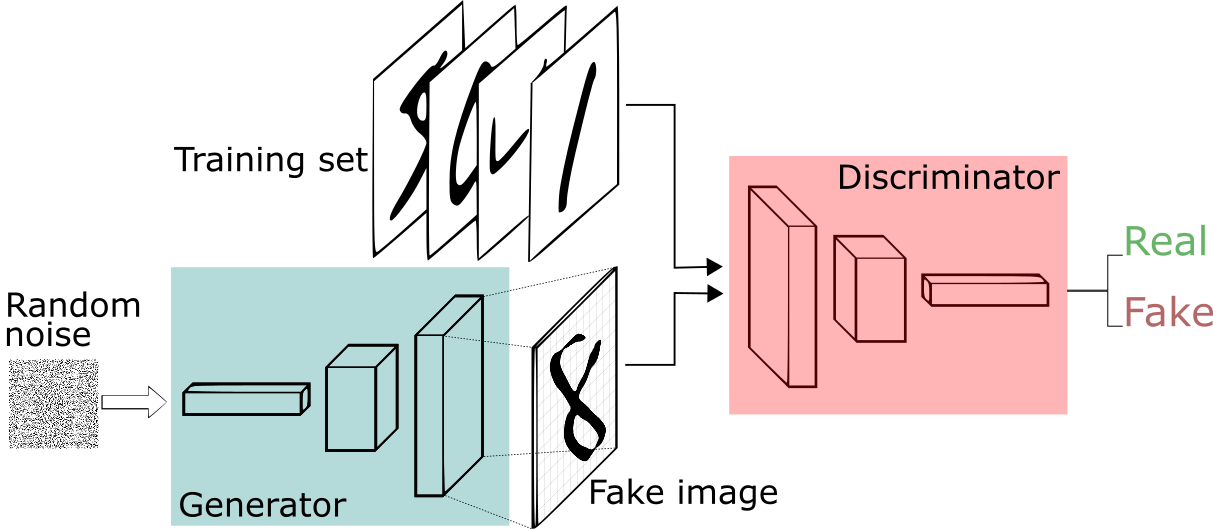

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# Optimizer's params
lr = 0.0002
beta1 = 0.5
beta2 = 0.99

# Training variables
epochs = 20

# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation((-20, +20))
])

In [5]:
train_data = datasets.MNIST(root='MNIST', train=True, download=True, transform=train_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 895068.68it/s] 


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133652.22it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272379.71it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5555709.76it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



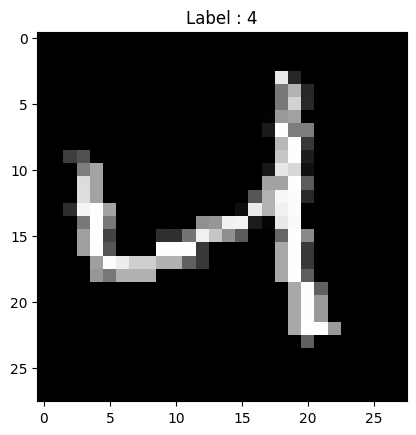

In [6]:
import matplotlib.pyplot as plt

image, label = train_data[2]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label : {label}')
plt.show()

In [7]:
print(f'Total number of images in dataset : {len(train_data)}')

Total number of images in dataset : 60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [10]:
print(f'Total number of batches : {len(train_loader)}')

Total number of batches : 469


In [11]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

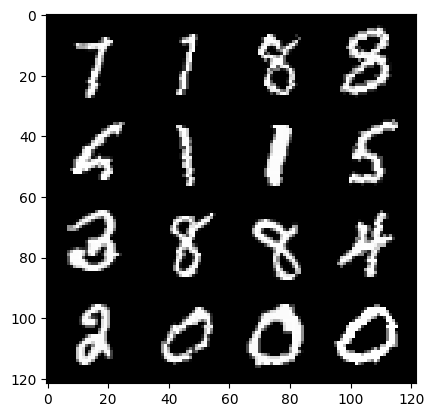

In [12]:
images, labels = next(iter(train_loader))
show_tensor_images(images)

# Create Discriminator Network

In [13]:
#In case if torch summary is not installed

!pip install torchsummary

In [14]:
import torch.nn as nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [15]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = get_disc_block(1, 16, (3,3), 2)
        self.block2 = get_disc_block(16, 32, (5,5), 2)
        self.block3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.flatten(x)
        x = self.linear(x)

        return x

In [17]:
summary(Discriminator().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [21]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [22]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.block1 = get_gen_block(z_dim, 256, (3,3), 2)
        self.block2 = get_gen_block(256, 128, (4,4), 1)
        self.block3 = get_gen_block(128, 64, (3,3), 2)

        self.block4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

    def forward(self, r_noise):
        x = r_noise.view(-1, noise_dim, 1, 1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        return x


In [23]:
summary(Generator(noise_dim).to(device), (noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [26]:
disc = Discriminator().to(device)
disc.apply(weights_init)

gen = Generator(noise_dim).to(device)
gen.apply(weights_init)

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [25]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.ones_like(disc_pred))
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [27]:
disc_optim = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2))
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | Discriminator Loss : 0.6781138349443611 | Generator Loss : 0.7102366712555956


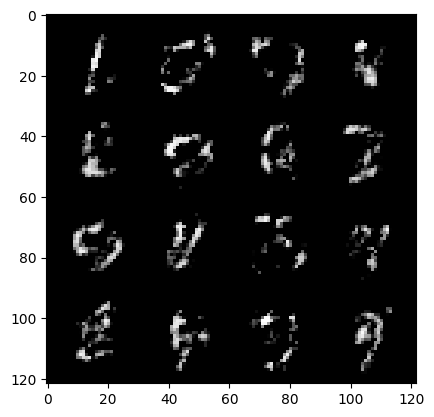

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | Discriminator Loss : 0.652548066715696 | Generator Loss : 0.7428927571534603


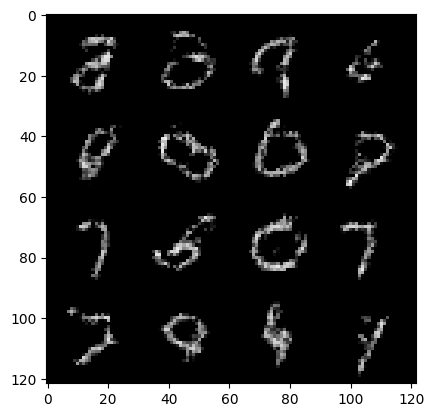

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | Discriminator Loss : 0.6070105709246735 | Generator Loss : 0.8008253052036391


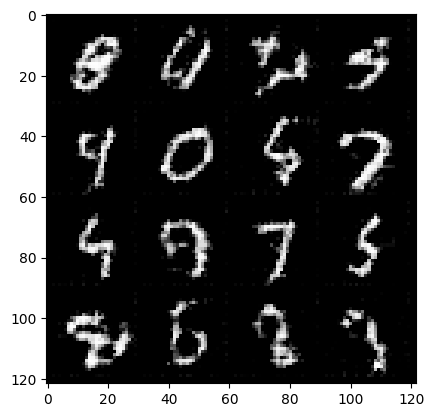

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | Discriminator Loss : 0.5912987530104387 | Generator Loss : 0.8311787514544245


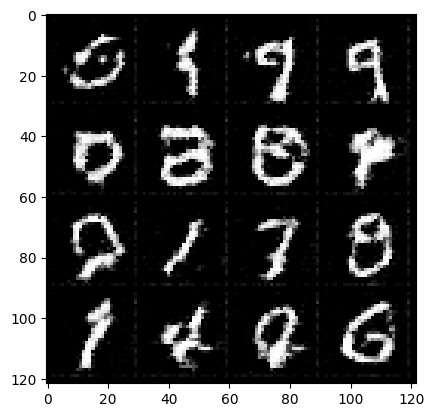

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | Discriminator Loss : 0.5942748553717314 | Generator Loss : 0.8434990692748698


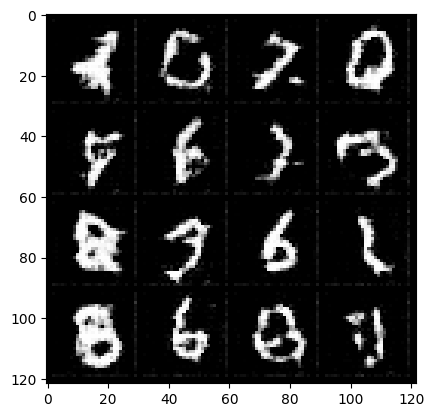

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | Discriminator Loss : 0.590726011343348 | Generator Loss : 0.8612421045679528


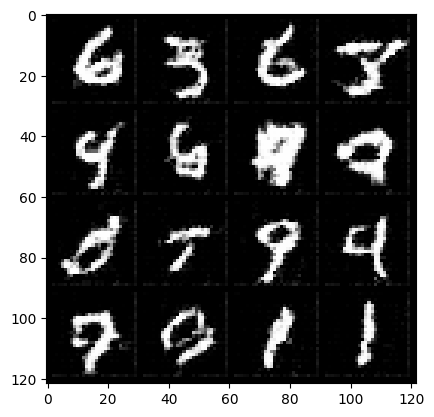

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | Discriminator Loss : 0.5978563899424538 | Generator Loss : 0.8624216743877956


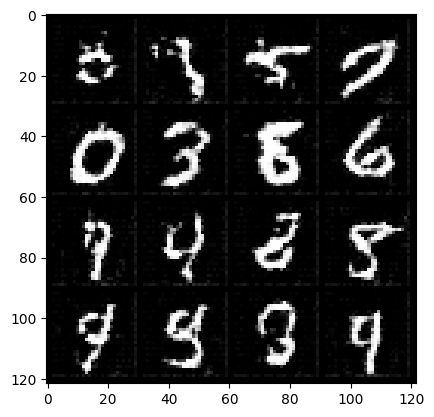

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | Discriminator Loss : 0.6084453604622945 | Generator Loss : 0.8570818775244105


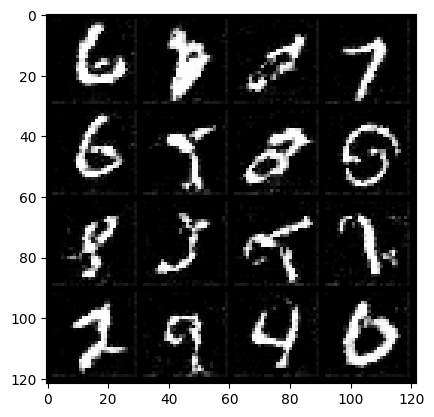

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | Discriminator Loss : 0.619055037432388 | Generator Loss : 0.8481509334751284


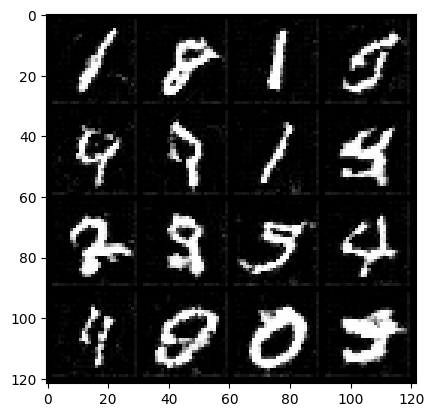

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | Discriminator Loss : 0.6259643861225673 | Generator Loss : 0.837587042403882


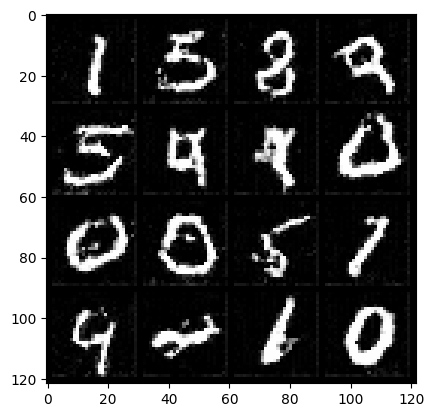

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | Discriminator Loss : 0.6306486307685055 | Generator Loss : 0.8349795717674532


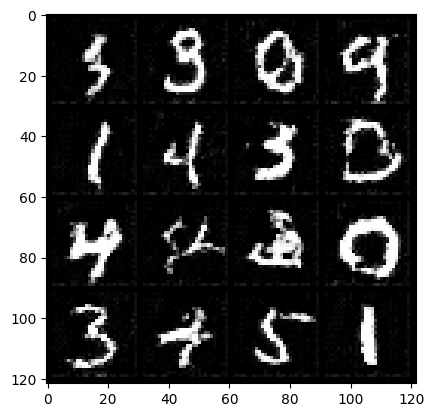

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | Discriminator Loss : 0.633341731293115 | Generator Loss : 0.8291830520894228


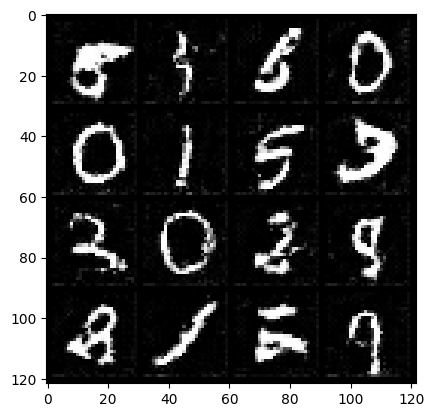

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | Discriminator Loss : 0.6349990847014161 | Generator Loss : 0.8293818624289051


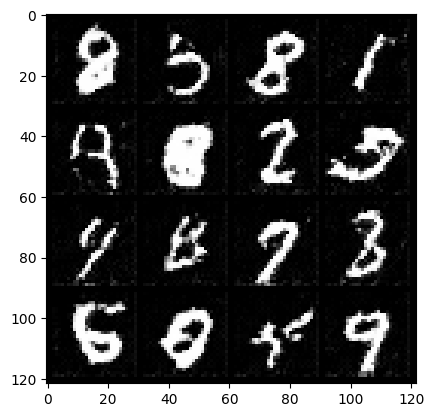

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | Discriminator Loss : 0.6351604625614468 | Generator Loss : 0.8292598627777751


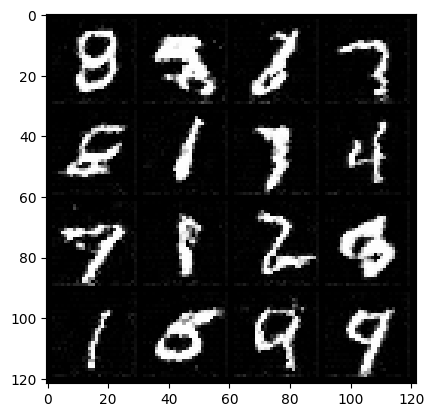

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | Discriminator Loss : 0.6368899875358224 | Generator Loss : 0.8243594899106381


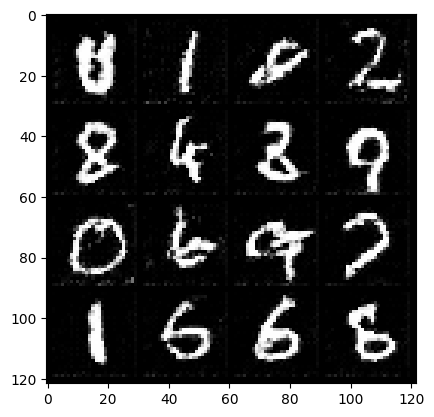

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | Discriminator Loss : 0.6392921092413636 | Generator Loss : 0.8238898600850787


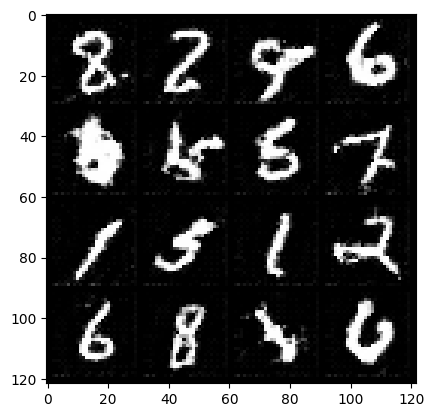

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | Discriminator Loss : 0.6381595785429737 | Generator Loss : 0.8254981390448776


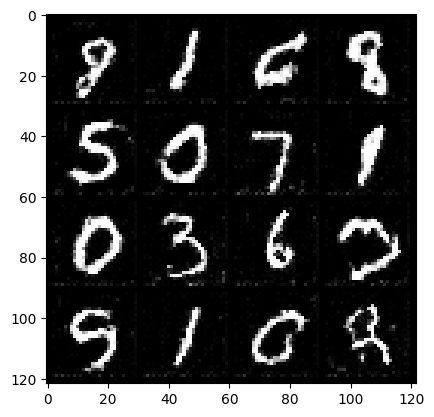

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | Discriminator Loss : 0.6390636264642419 | Generator Loss : 0.8259800719553982


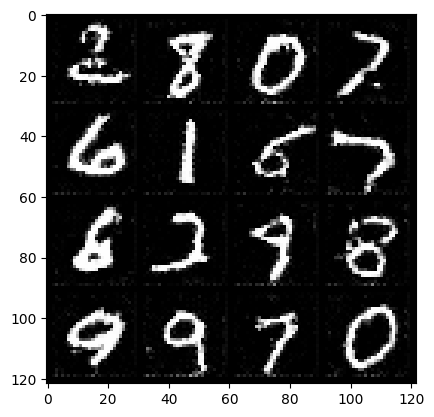

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | Discriminator Loss : 0.6376239422287768 | Generator Loss : 0.8273286420399192


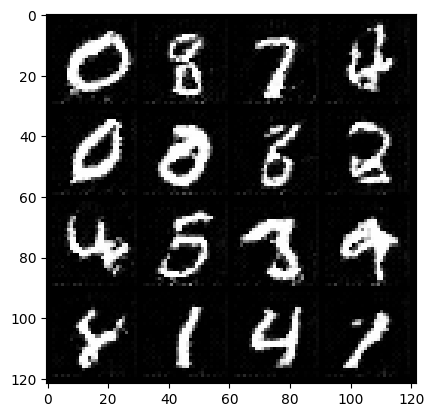

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | Discriminator Loss : 0.637101426053403 | Generator Loss : 0.8276055094275647


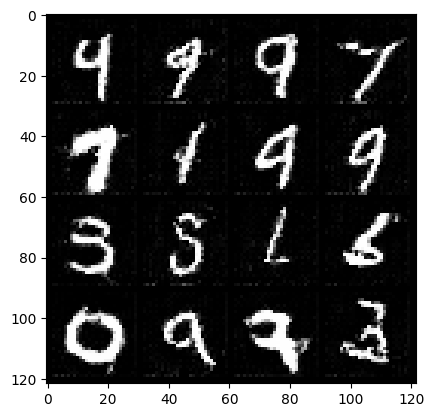

In [29]:
for epoch in range(epochs):
  total_disc_loss = 0
  total_gen_loss = 0
  for real_images, _ in tqdm(train_loader):
    real_images = real_images.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)
    fake_images = gen(noise)
    dic_fake_pred = disc(fake_images)
    dic_real_pred = disc(real_images)

    disc_fake_loss = fake_loss(dic_fake_pred)
    disc_real_loss = real_loss(dic_real_pred)

    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    total_disc_loss += disc_loss.item()

    disc_optim.zero_grad()
    disc_loss.backward()
    disc_optim.step()

    noise = torch.randn(batch_size, noise_dim, device=device)
    fake_images = gen(noise)
    disc_pred = disc(fake_images)
    gen_loss = real_loss(disc_pred)

    total_gen_loss += gen_loss.item()

    gen_optim.zero_grad()
    gen_loss.backward()
    gen_optim.step()

  print(f'Epoch : {epoch+1} | Discriminator Loss : {total_disc_loss/len(train_loader)} | Generator Loss : {total_gen_loss/len(train_loader)}')
  show_tensor_images(fake_images)


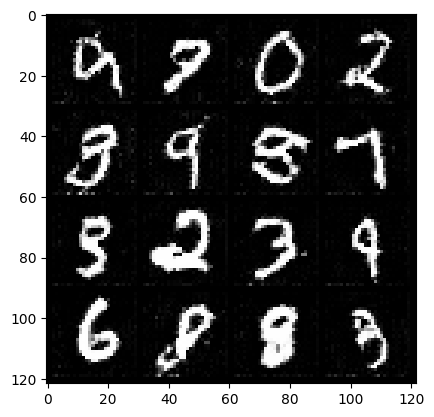

In [30]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = gen(noise)

show_tensor_images(generated_image)